Importing necessary libraries and loading dataset: 

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from pathlib import Path

In [2]:
data_path = 'C:/Users/Acer/Downloads/Sign Language Detection'
train_path = os.path.join(data_path, 'Train')
test_path = os.path.join(data_path, 'Test')


In [3]:
#Count Total Images in Train and Test Sets
def count_images(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

total_train = count_images(train_path)
total_test = count_images(test_path)

print(f"Total Training Images: {total_train}")
print(f"Total Testing Images: {total_test}")


Total Training Images: 11058
Total Testing Images: 3


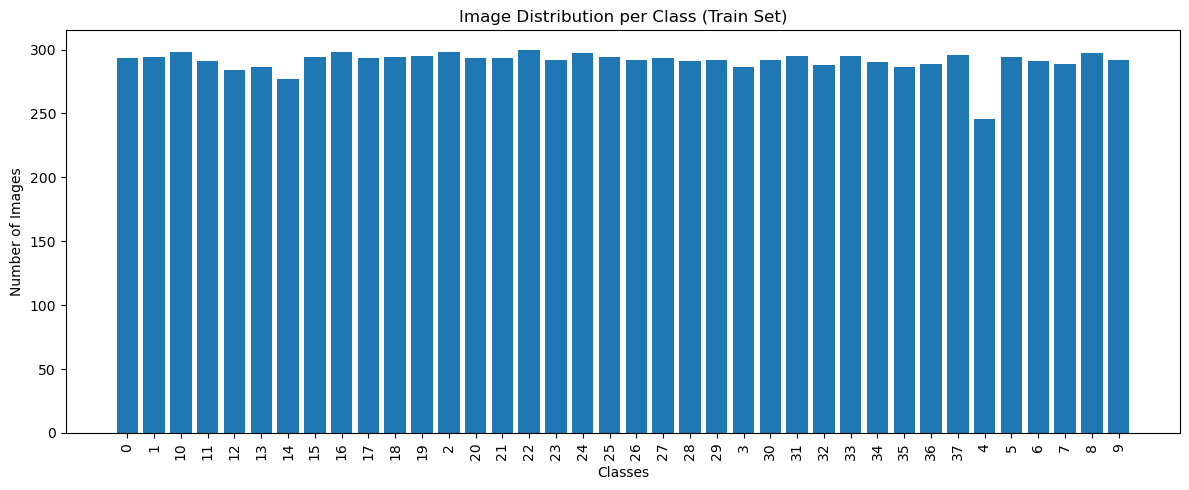

In [4]:
# Visualize Class Distribution
import matplotlib.pyplot as plt
from collections import Counter

def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

dist = get_class_distribution(train_path)
plt.figure(figsize=(12, 5))
plt.bar(dist.keys(), dist.values())
plt.xticks(rotation=90)
plt.title('Image Distribution per Class (Train Set)')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


Data Pre processing:

In [5]:
#corupt file handling
from PIL import Image
import os

def remove_corrupted_images(directory):
    corrupted_count = 0
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                img = Image.open(filepath)
                img.verify()  # Check for corruption
            except (IOError, SyntaxError, Image.DecompressionBombError):
                print(f"Deleting corrupted file: {filepath}")
                corrupted_count += 1
                os.remove(filepath)
    print(f"Total corrupted images removed from {directory}: {corrupted_count}")

# Run for both train and test directories
remove_corrupted_images(train_path)
remove_corrupted_images(test_path)


Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\20180625_221850.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\20180713_234254.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\20180718_224732.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\20180719_002600.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\DSC_1292.JPG
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\IMG_20180609_130454.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\0\IMG_20180716_075453.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\1\20180625_224200.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\1\20180716_003635.jpg
Deleting corrupted file: C:/Users/Acer/Downloads/Sign Language Detection\Train\1\DSC_1287.

In [6]:
#Use ImageDataGenerator for Preprocessing and Augmentation
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
image_size = (64, 64)
batch_size = 32

# Step 1: Build a dataframe of image paths and labels
filepaths = []
labels = []

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_name)

df = pd.DataFrame({'filename': filepaths, 'class': labels})

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

# Step 3: Set up ImageDataGenerators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

# Step 4: Load from DataFrame
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_test_gen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 6906 validated image filenames belonging to 38 classes.
Found 1727 validated image filenames belonging to 38 classes.
Found 2159 validated image filenames belonging to 38 classes.


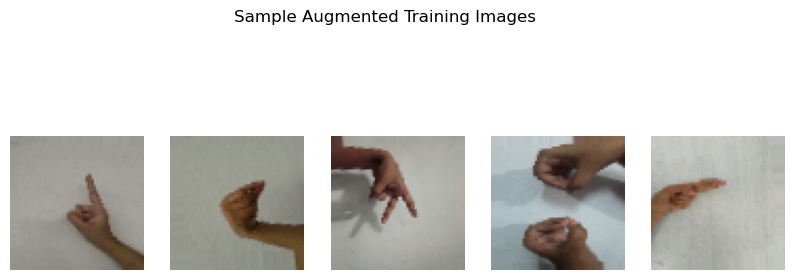

In [7]:
#Sample Augmented Training Images
x_batch, y_batch = next(train_data)

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle("Sample Augmented Training Images")
plt.show()


Base Model Building:

In [ ]:
#Baseline CNN Model Implementation

num_classes = len(train_data.class_indices)

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(256, activation='relu'),

    Dense(128, activation='relu'),

    Dense(num_classes, activation='softmax')
])

baseline_model.summary()


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310,950 (5.00 MB)

 Trainable params: 1,310,950 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Compile and Train the Model
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = baseline_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
)


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - accuracy: 0.0285 - loss: 3.6271 - val_accuracy: 0.1170 - val_loss: 3.2815
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.1274 - loss: 3.2062 - val_accuracy: 0.2583 - val_loss: 2.5686
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.2483 - loss: 2.6058 - val_accuracy: 0.3382 - val_loss: 2.2543
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.3472 - loss: 2.1844 - val_accuracy: 0.4661 - val_loss: 1.7446
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.4508 - loss: 1.8016 - val_accuracy: 0.4945 - val_loss: 1.5710
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.5222 - loss: 1.5561 - val_accuracy: 0.5987 - val_loss: 1.2429
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.5636 - loss: 1.4222 - val_accuracy: 0.6532 - val_loss: 1.1058
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.6147 - loss: 1.

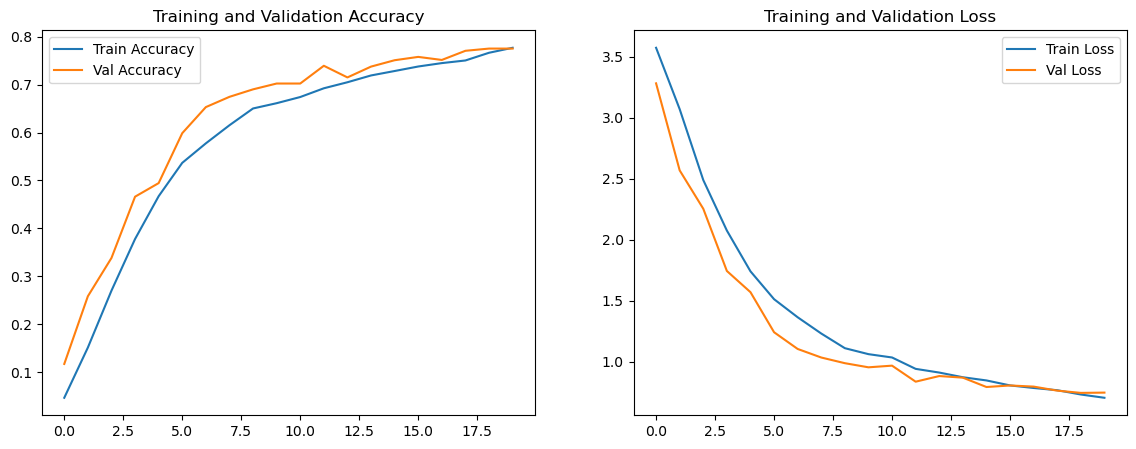

In [10]:
### Plot Training and Validation Loss/Accuracy
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)


In [11]:
#Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
preds = baseline_model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        57
           1       0.84      0.91      0.87        57
          10       0.88      0.90      0.89        58
          11       0.87      0.93      0.90        57
          12       0.86      0.78      0.82        55
          13       0.74      0.75      0.74        56
          14       0.53      0.69      0.60        54
          15       0.64      0.82      0.72        57
          16       0.80      0.90      0.85        58
          17       0.94      0.81      0.87        57
          18       0.68      0.45      0.54        58
          19       0.78      0.36      0.49        58
           2       0.90      0.90      0.90        58
          20       0.75      0.82      0.78        57
          21       0.82      0.89      0.86        57
          22       0.79      0.71      0.75        59
          23       0.55      0.49    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


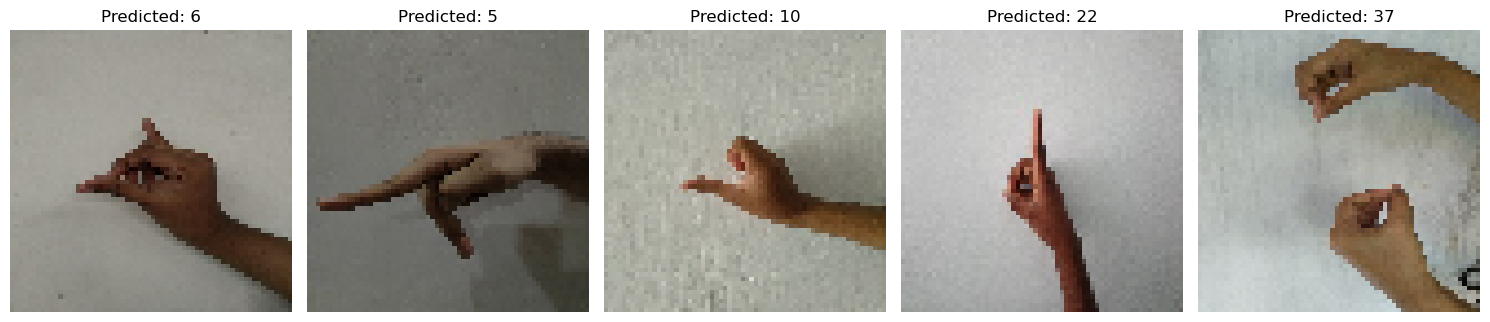

In [12]:
#test base model
import random

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx = random.randint(0, len(test_data.filenames) - 1)
    img_path = os.path.join(test_path, test_data.filenames[idx])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    prediction = baseline_model.predict(tf.expand_dims(img_array, axis=0))
    pred_label = class_labels[np.argmax(prediction)]

    axes[i].imshow(img_array)
    axes[i].set_title(f"Predicted: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [13]:
#base model accuracy
loss, accuracy = baseline_model.evaluate(test_data, verbose=0)
print(f"\nBase model Accuracy: {accuracy:.10f}")


Base model Accuracy: 0.7924965024


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


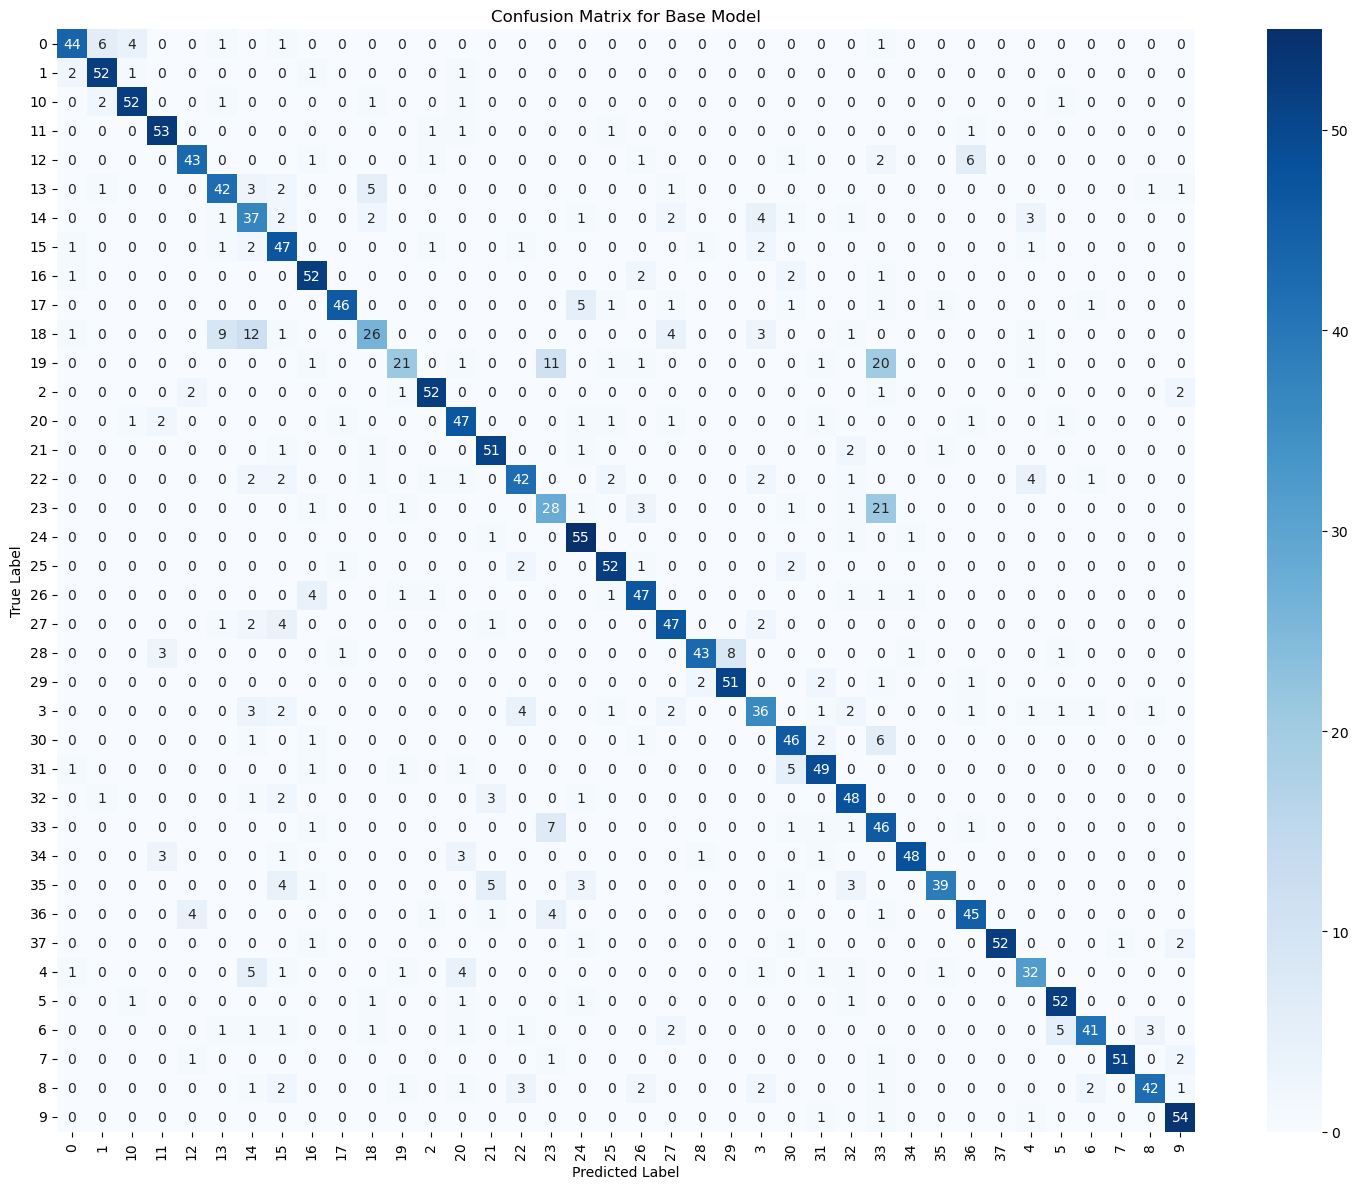

In [14]:
import seaborn as sns
# Predict on test data
y_pred_base = np.argmax(baseline_model.predict(test_data), axis=1)
y_true_base = test_data.classes
class_labels_base = list(test_data.class_indices.keys())

# Compute confusion matrix
cm_base = confusion_matrix(y_true_base, y_pred_base)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_base, yticklabels=class_labels_base)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Base Model')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Deeper model: 

In [ ]:
#deeper CNN model with regularization

deeper_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(120, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')
])


deeper_model.summary()


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 120)    │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       276,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,150 (3.94 MB)

 Trainable params: 1,032,206 (3.94 MB)

 Non-trainable params: 944 (3.69 KB)

In [ ]:
#Train the Deeper Model with adam optimizer
deeper_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deeper_history = deeper_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True)]
)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.0365 - loss: 5.2810 - val_accuracy: 0.0266 - val_loss: 4.9758
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - accuracy: 0.0840 - loss: 4.5785 - val_accuracy: 0.0365 - val_loss: 4.6525
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.1472 - loss: 4.0211 - val_accuracy: 0.1859 - val_loss: 3.7896
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.2209 - loss: 3.5382 - val_accuracy: 0.1071 - val_loss: 4.3476
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.2931 - loss: 3.1169 - val_accuracy: 0.4233 - val_loss: 2.6380
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.3538 - loss: 2.8701 - val_accuracy: 0.4111 - val_loss: 2.6726
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.4244 - loss: 2.6317 - val_accuracy: 0.3115 - val_loss: 2.9350
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.4597 - loss: 2

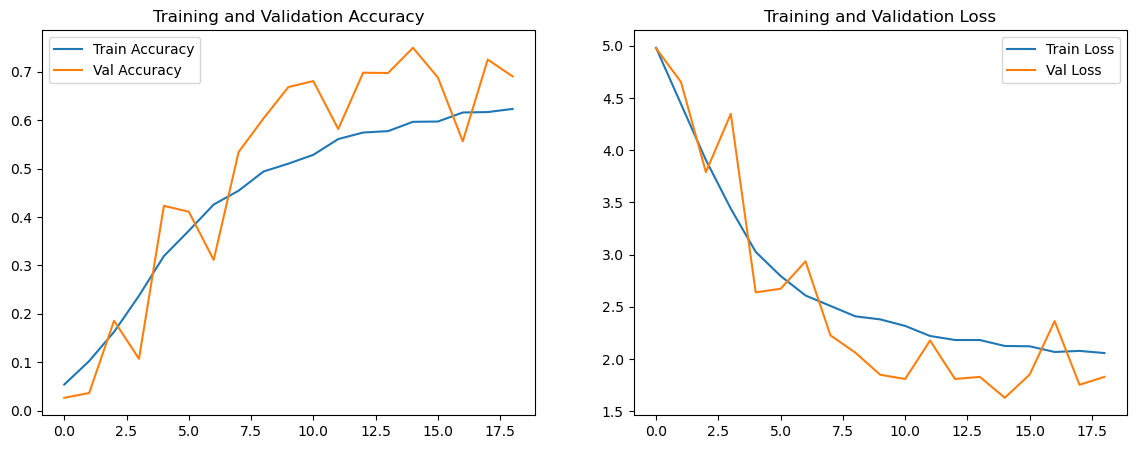

In [17]:
#Plot training vs validation curves
plot_metrics(deeper_history)


In [18]:
#Evaluate the Deeper Model
# Predictions
deeper_preds = deeper_model.predict(test_data)
deeper_y_pred = np.argmax(deeper_preds, axis=1)

# Evaluation metrics
print("Deeper Model Classification Report:")
print(classification_report(y_true, deeper_y_pred, target_names=class_labels))


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Deeper Model Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        57
           1       0.81      0.96      0.88        57
          10       0.96      0.86      0.91        58
          11       0.75      0.91      0.83        57
          12       0.80      0.78      0.79        55
          13       1.00      0.32      0.49        56
          14       0.54      0.65      0.59        54
          15       0.81      0.51      0.62        57
          16       0.98      0.72      0.83        58
          17       0.92      0.86      0.89        57
          18       0.64      0.60      0.62        58
          19       0.60      0.50      0.55        58
           2       0.84      0.88      0.86        58
          20       0.92      0.60      0.72        57
          21       0.89      0.72      0.80        57
          22       0.64      0.80      0.71        59
  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


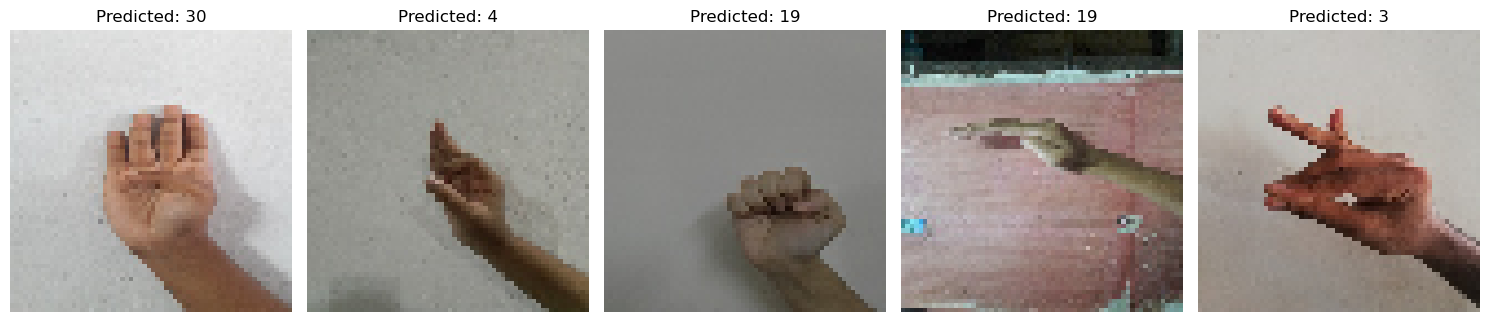

In [19]:
#test
import random

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx = random.randint(0, len(test_data.filenames) - 1)
    img_path = os.path.join(test_path, test_data.filenames[idx])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    prediction = deeper_model.predict(tf.expand_dims(img_array, axis=0))
    pred_label = class_labels[np.argmax(prediction)]

    axes[i].imshow(img_array)
    axes[i].set_title(f"Predicted: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [20]:
#Accuracy Of deeper model
loss, accuracy = deeper_model.evaluate(test_data, verbose=0)
print(f"\nDeeper Model Accuracy: {accuracy:.10f}")


Deeper Model Accuracy: 0.7665585876


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


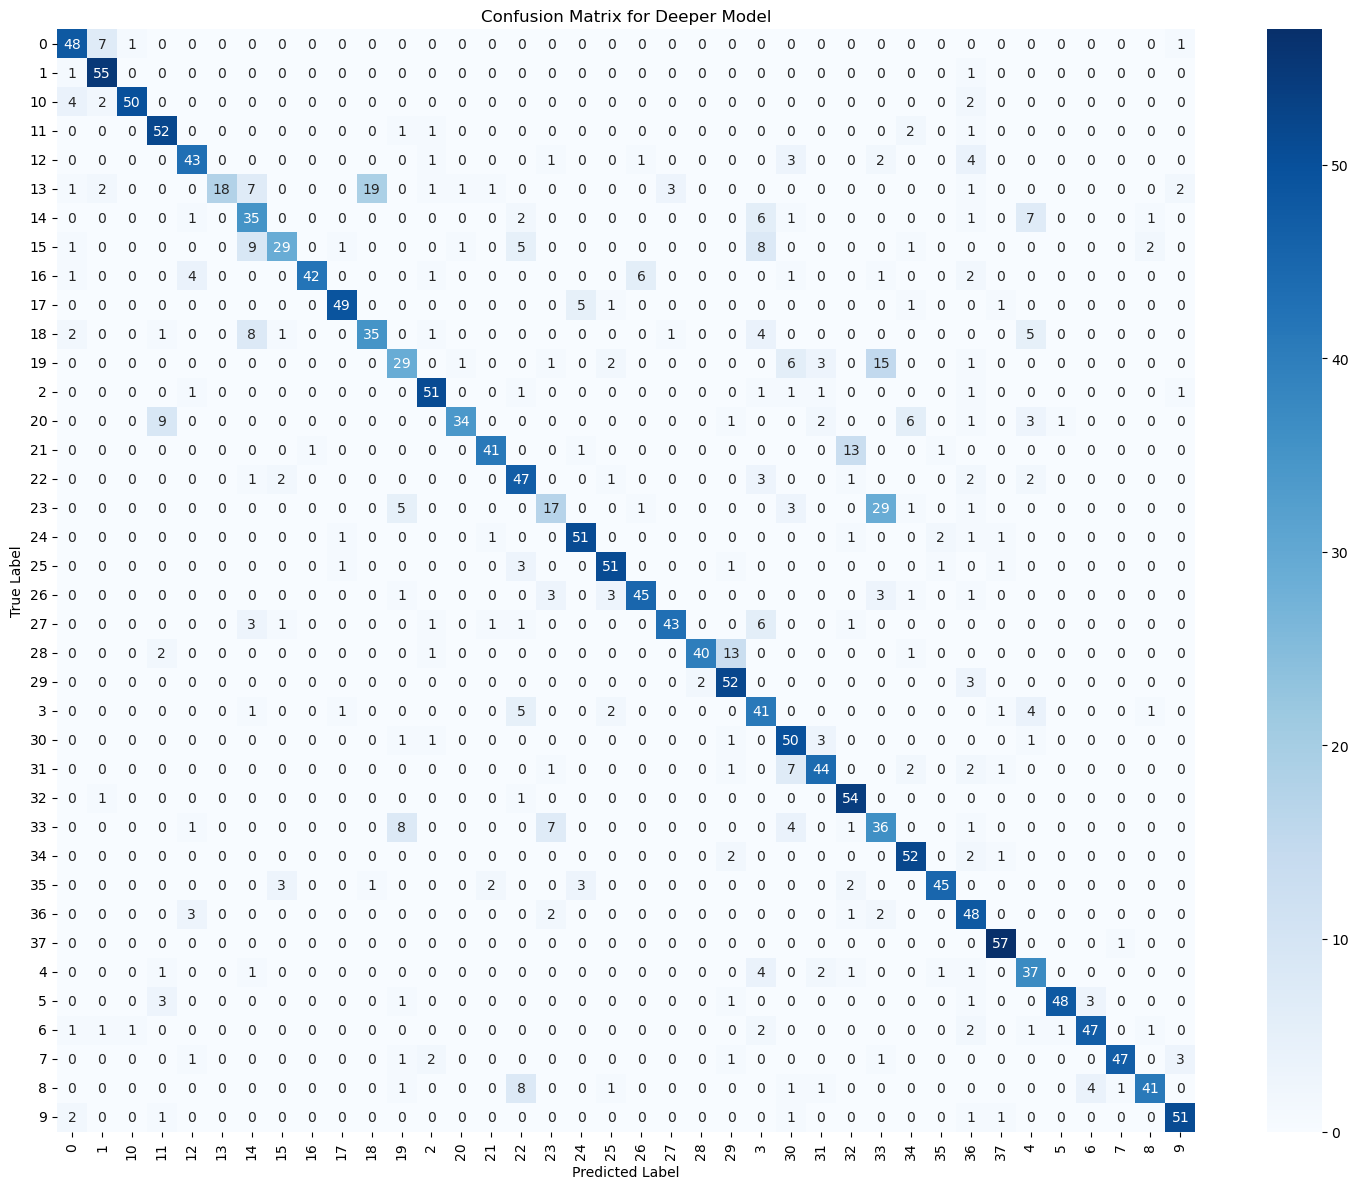

In [21]:
# Predict on test data
y_pred_deep = np.argmax(deeper_model.predict(test_data), axis=1)
y_true_deep = test_data.classes
class_labels_deep = list(test_data.class_indices.keys())

# Compute confusion matrix
cm_deep = confusion_matrix(y_true_deep, y_pred_deep)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_deep, yticklabels=class_labels_deep)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Deeper Model')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

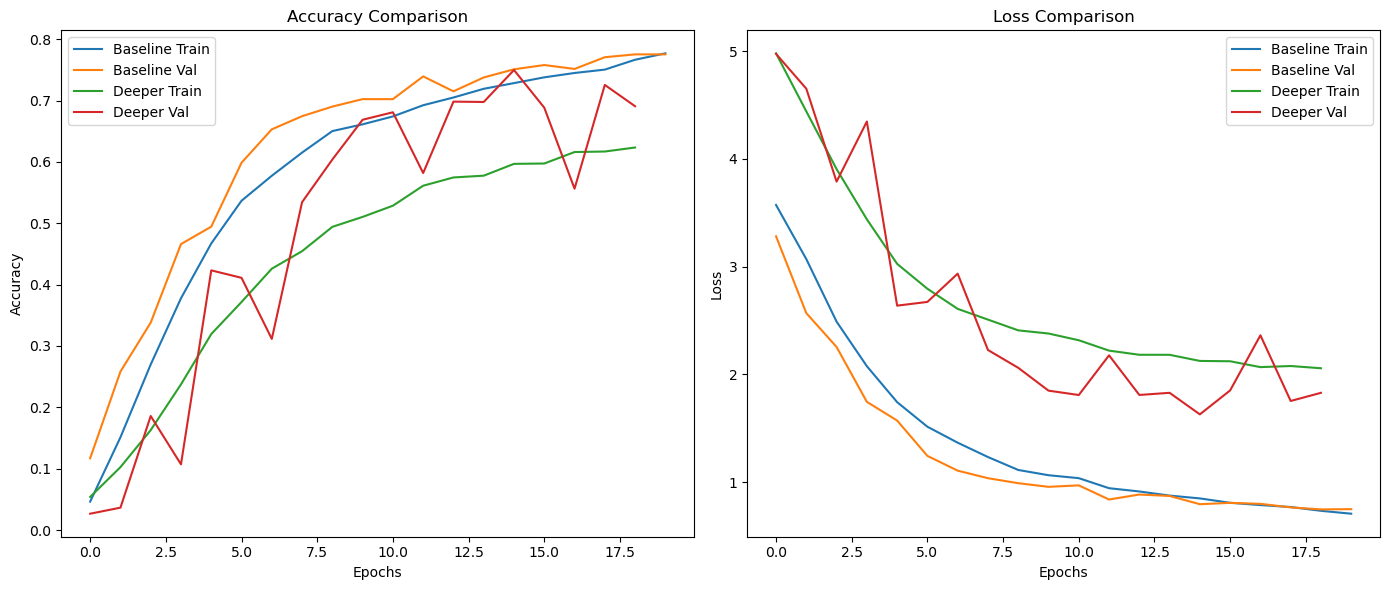

In [22]:
#Training vs Validation Curves Comparison
def plot_comparison(history1, history2, label1="Baseline", label2="Deeper"):
    plt.figure(figsize=(14, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label=f'{label1} Train')
    plt.plot(history1.history['val_accuracy'], label=f'{label1} Val')
    plt.plot(history2.history['accuracy'], label=f'{label2} Train')
    plt.plot(history2.history['val_accuracy'], label=f'{label2} Val')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label=f'{label1} Train')
    plt.plot(history1.history['val_loss'], label=f'{label1} Val')
    plt.plot(history2.history['loss'], label=f'{label2} Train')
    plt.plot(history2.history['val_loss'], label=f'{label2} Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(history, deeper_history)


Deeper Model With SGD optimizer:

In [23]:

#Compile and Train the Deeper Model with SGD
from tensorflow.keras.optimizers import SGD

sgd_model = tf.keras.models.clone_model(deeper_model)
sgd_model.set_weights(deeper_model.get_weights())
sgd_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

sgd_history = sgd_model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True)]
)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 147ms/step - accuracy: 0.6109 - loss: 2.0915 - val_accuracy: 0.1257 - val_loss: 4.1026
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.6206 - loss: 2.0465 - val_accuracy: 0.4997 - val_loss: 2.6917
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.6484 - loss: 1.9256 - val_accuracy: 0.7331 - val_loss: 1.6970
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.6404 - loss: 1.9544 - val_accuracy: 0.6815 - val_loss: 1.8572
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - accuracy: 0.6673 - loss: 1.8670 - val_accuracy: 0.7823 - val_loss: 1.5018
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.6677 - loss: 1.8556 - val_accuracy: 0.6891 - val_loss: 1.8121
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.6706 - loss: 1.8357 - val_accuracy: 0.7458 - val_loss: 1.6205
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.6785 - loss: 1

In [24]:
#Evaluate SGD-Trained Model
sgd_preds = sgd_model.predict(test_data)
sgd_y_pred = np.argmax(sgd_preds, axis=1)

print("SGD Model Classification Report:")
print(classification_report(y_true, sgd_y_pred, target_names=class_labels))


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
SGD Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.78        57
           1       0.84      0.95      0.89        57
          10       0.89      0.93      0.91        58
          11       0.88      0.93      0.91        57
          12       0.81      0.80      0.81        55
          13       0.61      0.62      0.62        56
          14       0.49      0.83      0.62        54
          15       0.73      0.58      0.65        57
          16       0.89      0.86      0.88        58
          17       0.91      0.88      0.89        57
          18       0.74      0.50      0.60        58
          19       0.65      0.38      0.48        58
           2       0.93      0.90      0.91        58
          20       0.82      0.89      0.86        57
          21       0.86      0.96      0.91        57
          22       0.76      0.76      0.76        59
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


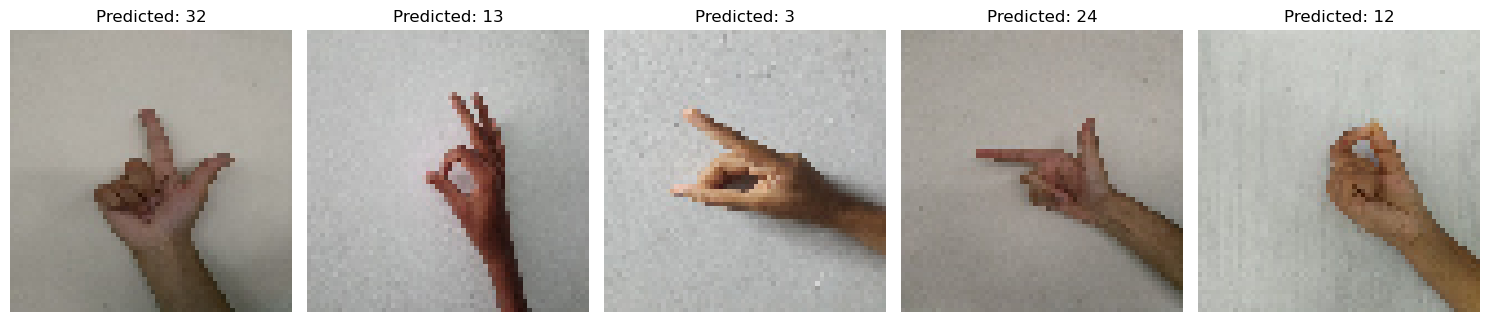

In [25]:
#test on sgd
import random

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx = random.randint(0, len(test_data.filenames) - 1)
    img_path = os.path.join(test_path, test_data.filenames[idx])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    prediction = sgd_model.predict(tf.expand_dims(img_array, axis=0))
    pred_label = class_labels[np.argmax(prediction)]

    axes[i].imshow(img_array)
    axes[i].set_title(f"Predicted: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [26]:
#SGD Model accuracy
loss, accuracy = sgd_model.evaluate(test_data, verbose=0)
print(f"\nSGD model Accuracy: {accuracy:.10f}")


SGD model Accuracy: 0.7874015570


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


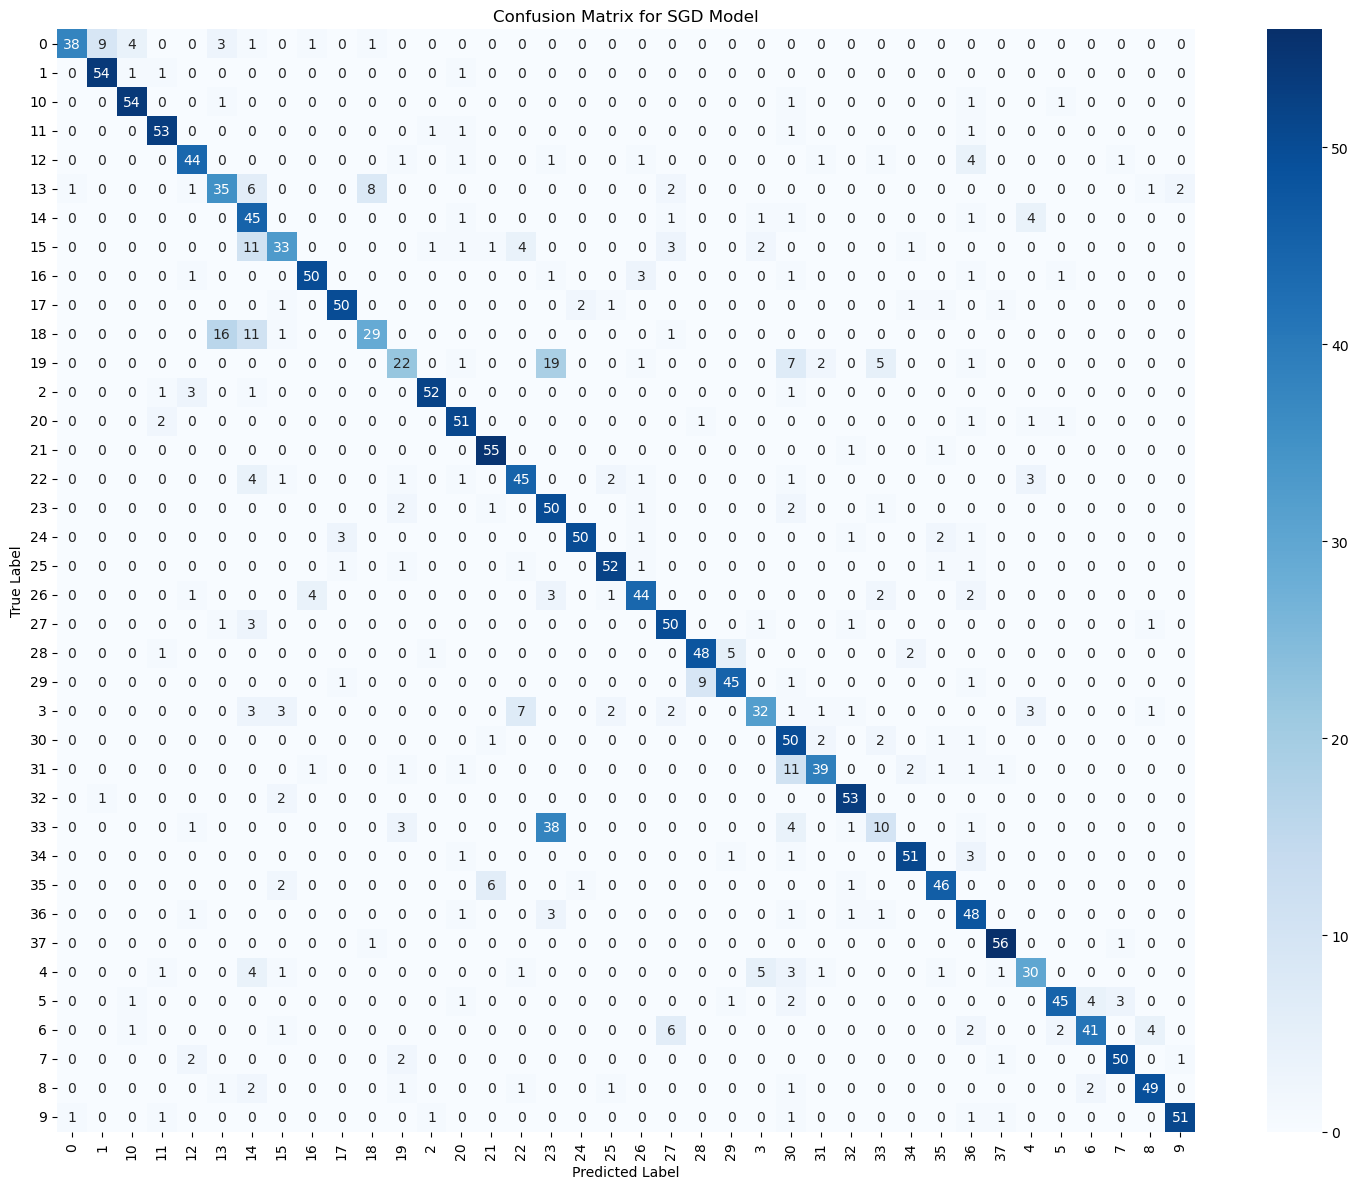

In [27]:
# Predict on test data
y_pred_sgd = np.argmax(sgd_model.predict(test_data), axis=1)
y_true_sgd = test_data.classes
class_labels_sgd = list(test_data.class_indices.keys())

# Compute confusion matrix
cm_sgd = confusion_matrix(y_true_sgd, y_pred_sgd)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_sgd, yticklabels=class_labels_sgd)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SGD Model')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

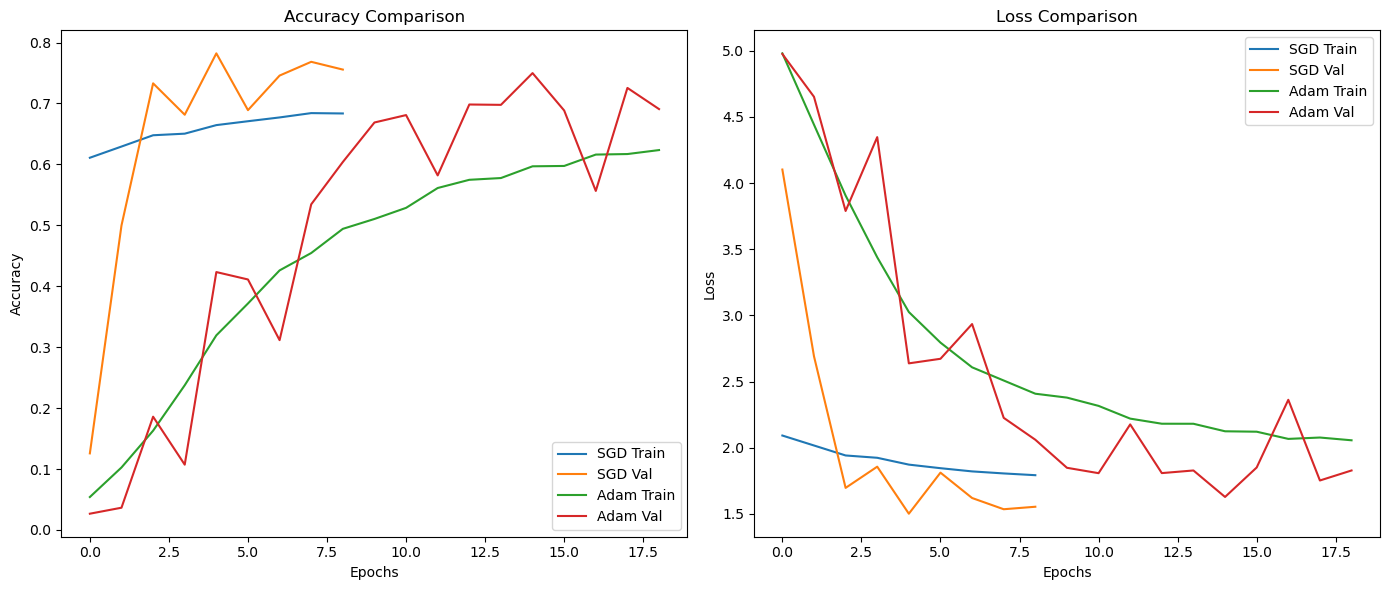

In [28]:
#Compare SGD vs Adam Training Curves
plot_comparison(sgd_history, deeper_history, label1="SGD", label2="Adam")

Transfer Model: 

In [29]:
# Define new image size and batch size
image_size_transfer = (224, 224)
batch_size_transfer = 32

# Step 1: Build dataframe
filepaths_t = []
labels_t = []

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths_t.append(os.path.join(class_dir, fname))
                labels_t.append(class_name)

df_transfer = pd.DataFrame({'filename': filepaths_t, 'class': labels_t})

train_df_t, test_df_t = train_test_split(df_transfer, test_size=0.2, stratify=df_transfer['class'], random_state=42)
train_df_t, val_df_t = train_test_split(train_df_t, test_size=0.2, stratify=train_df_t['class'], random_state=42)

# Step 2: Data Generators
train_gen_t = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_test_gen_t = ImageDataGenerator(rescale=1./255)

# Step 3: Data Flow
train_data_t = train_gen_t.flow_from_dataframe(
    train_df_t, x_col='filename', y_col='class',
    target_size=image_size_transfer, batch_size=batch_size_transfer,
    class_mode='categorical'
)

val_data_t = val_test_gen_t.flow_from_dataframe(
    val_df_t, x_col='filename', y_col='class',
    target_size=image_size_transfer, batch_size=batch_size_transfer,
    class_mode='categorical', shuffle=False
)

test_data_t = val_test_gen_t.flow_from_dataframe(
    test_df_t, x_col='filename', y_col='class',
    target_size=image_size_transfer, batch_size=1,
    class_mode='categorical', shuffle=False
)

class_labels_t = list(train_data_t.class_indices.keys())
num_classes_t = len(class_labels_t)

Found 6906 validated image filenames belonging to 38 classes.
Found 1727 validated image filenames belonging to 38 classes.
Found 2159 validated image filenames belonging to 38 classes.


In [30]:
#Loading and Adapting a Pre-Trained Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 with 224x224 input
base_model_t = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_t.trainable = False

# Add custom layers
x_t = base_model_t.output
x_t = GlobalAveragePooling2D()(x_t)
x_t = Dropout(0.25)(x_t)
x_t = Dense(128, activation='relu')(x_t)
output_t = Dense(num_classes_t, activation='softmax')(x_t)

transfer_model_t = Model(inputs=base_model_t.input, outputs=output_t)

# Compile
transfer_model_t.compile(
    optimizer=Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model_t.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
#Feature Extraction: Freeze base model
history_transfer_t = transfer_model_t.fit(
    train_data_t,
    epochs=20,
    validation_data=val_data_t,
    validation_steps=len(val_df_t) // batch_size_transfer,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True)]
)

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 161s 728ms/step - accuracy: 0.2082 - loss: 2.9613 - val_accuracy: 0.5696 - val_loss: 1.2779
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 157s 725ms/step - accuracy: 0.5659 - loss: 1.3323 - val_accuracy: 0.6568 - val_loss: 1.0564
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 156s 724ms/step - accuracy: 0.6471 - loss: 1.0543 - val_accuracy: 0.7034 - val_loss: 0.9271
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 156s 723ms/step - accuracy: 0.6625 - loss: 1.0215 - val_accuracy: 0.6934 - val_loss: 0.9367
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 157s 726ms/step - accuracy: 0.6666 - loss: 0.9804 - val_accuracy: 0.7223 - val_loss: 0.8680
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 158s 729ms/step - accuracy: 0.6829 - loss: 0.9721 - val_accuracy: 0.6910 - val_loss: 0.9244
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 182s 844ms/step - accuracy: 0.6825 - loss: 0.9656 - val_accuracy: 0.6952 - val_loss: 0.9295
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 175s 808ms/step - accuracy: 0.6846 -

In [36]:
base_model_t.trainable = True
for layer in base_model_t.layers[:-20]:  # Freeze all except last 20 layers
    layer.trainable = False

transfer_model_t.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history_t = transfer_model_t.fit(
    train_data_t,
    epochs=20,
    validation_data=val_data_t,
    validation_steps=len(val_df_t) // batch_size_transfer,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True)]
)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 182s 813ms/step - accuracy: 0.5587 - loss: 1.4535 - val_accuracy: 0.2441 - val_loss: 9.3951
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 175s 810ms/step - accuracy: 0.7993 - loss: 0.6196 - val_accuracy: 0.2842 - val_loss: 7.9152
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 173s 801ms/step - accuracy: 0.8450 - loss: 0.4509 - val_accuracy: 0.4782 - val_loss: 4.2496
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 174s 805ms/step - accuracy: 0.8754 - loss: 0.3814 - val_accuracy: 0.2818 - val_loss: 10.9750
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 173s 799ms/step - accuracy: 0.8858 - loss: 0.3316 - val_accuracy: 0.5454 - val_loss: 3.1878
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 173s 800ms/step - accuracy: 0.9174 - loss: 0.2534 - val_accuracy: 0.6757 - val_loss: 1.9005
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 173s 799ms/step - accuracy: 0.9254 - loss: 0.2343 - val_accuracy: 0.6268 - val_loss: 2.3339
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 173s 799ms/step - accuracy: 0.9395 

In [37]:
# Evaluation
preds_t = transfer_model_t.predict(test_data_t)
y_pred_t = np.argmax(preds_t, axis=1)
y_true_t = np.argmax(test_data_t.labels, axis=0)

print("Transfer Learning Model Report (224x224):")
print(classification_report(test_data_t.classes, y_pred_t, target_names=class_labels_t))

# Accuracy
loss_t, accuracy_t = transfer_model_t.evaluate(test_data_t, verbose=0)
print(f"\nTransfer Model Accuracy (224x224): {accuracy_t:.4f}")


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step
Transfer Learning Model Report (224x224):
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        57
           1       0.90      0.98      0.94        57
          10       0.83      0.95      0.89        58
          11       0.78      1.00      0.88        57
          12       0.90      0.85      0.88        55
          13       0.66      0.93      0.77        56
          14       0.86      0.70      0.78        54
          15       0.95      0.67      0.78        57
          16       0.89      1.00      0.94        58
          17       0.96      0.95      0.96        57
          18       0.88      0.50      0.64        58
          19       0.91      0.17      0.29        58
           2       0.85      0.95      0.89        58
          20       0.98      0.77      0.86        57
          21       1.00      0.74      0.85        57
          22       0.84      0.81      0.83     

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


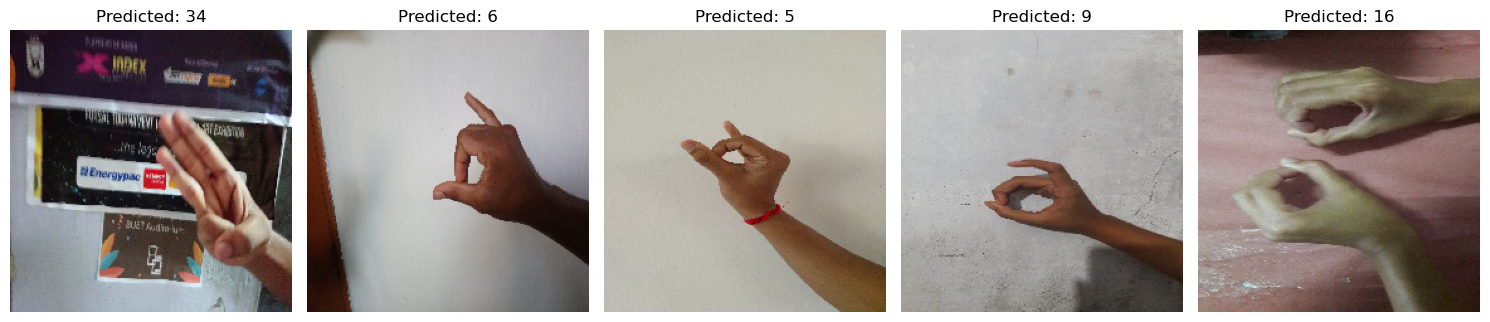

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx = random.randint(0, len(test_data_t.filenames) - 1)
    img_path = test_data_t.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size_transfer)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    prediction = transfer_model_t.predict(tf.expand_dims(img_array, axis=0))
    pred_label = class_labels_t[np.argmax(prediction)]

    axes[i].imshow(img_array)
    axes[i].set_title(f"Predicted: {pred_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [81]:
#Transfer model accuracy
loss_t, accuracy_t = transfer_model_t.evaluate(test_data_t, verbose=0)
print(f"\nTransfer Model Accuracy (224x224): {accuracy_t:.4f}")


Transfer Model Accuracy (224x224): 0.8476


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step


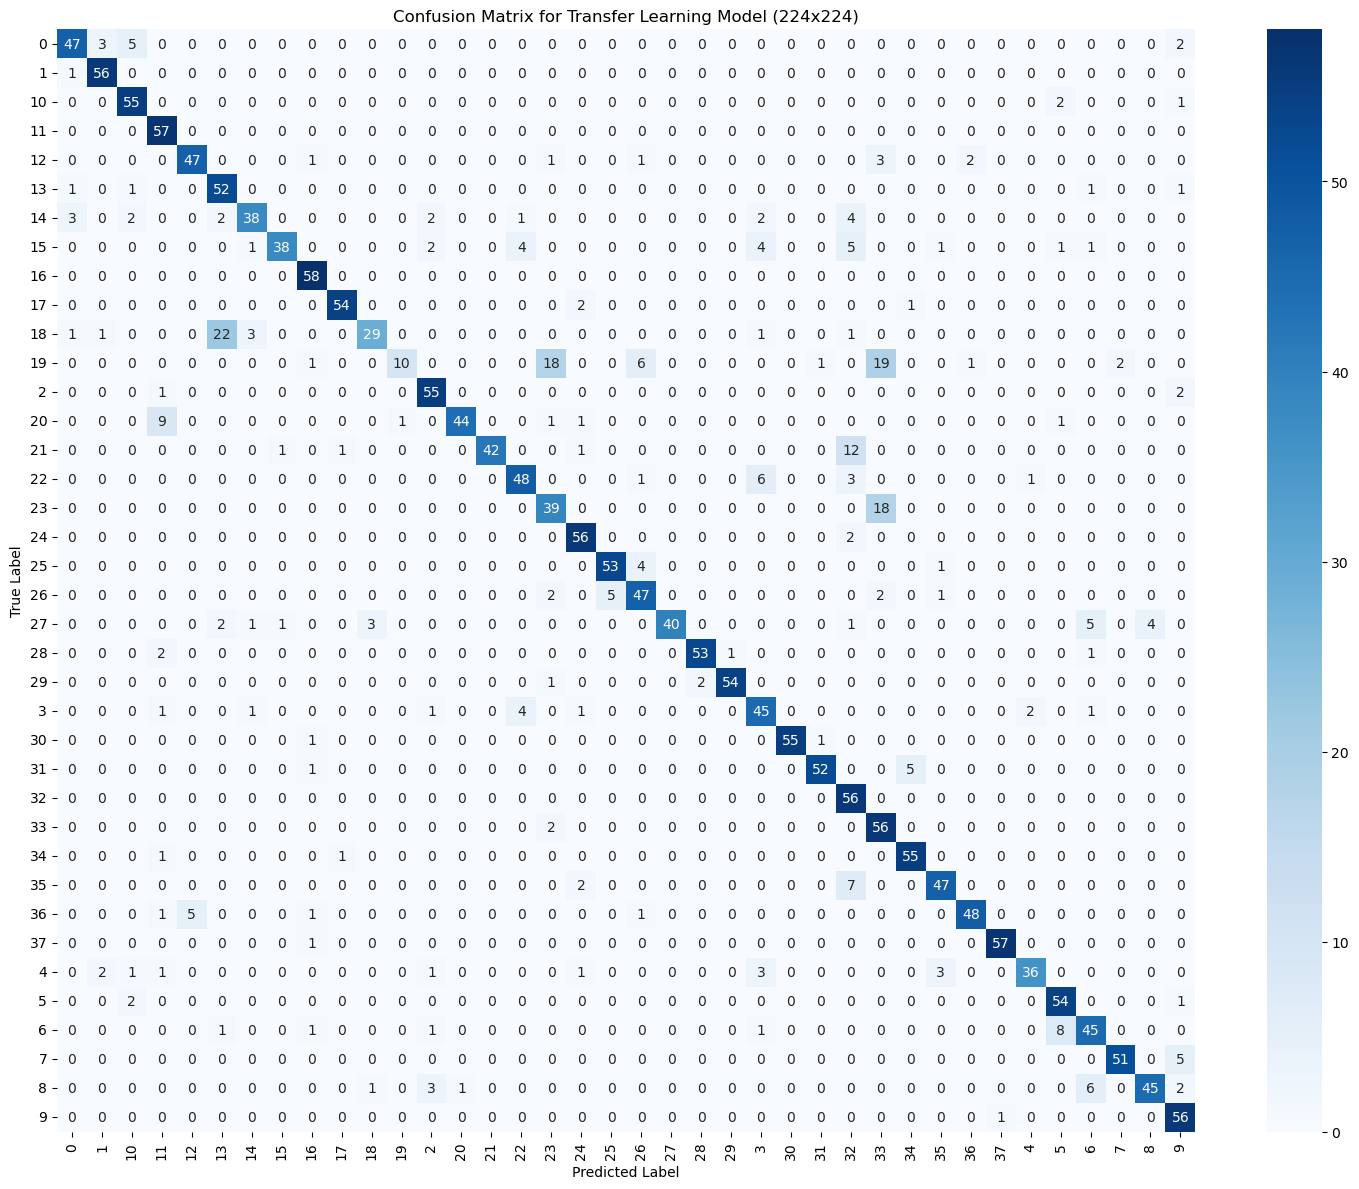

In [40]:
# Get predictions and true labels
y_pred_t = np.argmax(transfer_model_t.predict(test_data_t), axis=1)
y_true_t = test_data_t.classes
class_labels_t = list(test_data_t.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true_t, y_pred_t)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_t, yticklabels=class_labels_t)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Transfer Learning Model (224x224)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Comparison of all the Models:

Base Model Accuracy:     0.7925
Deeper Model Accuracy:   0.7666
SGD Model Accuracy:      0.7874
Transfer Model Accuracy: 0.8476


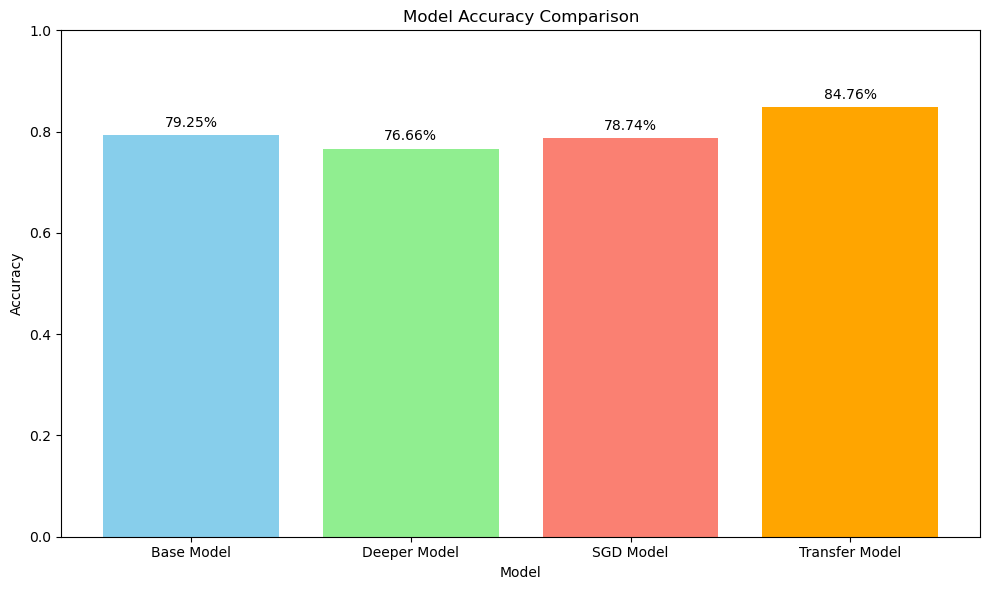

In [85]:
#ALl models comparison

# Evaluate all models on the test data
loss_base, acc_base = baseline_model.evaluate(test_data, verbose=0)
loss_deeper, acc_deeper = deeper_model.evaluate(test_data, verbose=0)
loss_sgd, acc_sgd = sgd_model.evaluate(test_data, verbose=0)
loss_transfer, acc_transfer = transfer_model_t.evaluate(test_data, verbose=0)

# Print accuracies
print(f"Base Model Accuracy:     {acc_base:.4f}")
print(f"Deeper Model Accuracy:   {acc_deeper:.4f}")
print(f"SGD Model Accuracy:      {acc_sgd:.4f}")
print(f"Transfer Model Accuracy: {accuracy_t:.4f}")

# Labels and values
model_names = ['Base Model', 'Deeper Model', 'SGD Model', 'Transfer Model']
accuracies = [acc_base, acc_deeper, acc_sgd, accuracy_t]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Annotate bars with accuracy values
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
